In [ ]:
import kagglehub
path = kagglehub.dataset_download("frankossai/apple-stock-aapl-historical-financial-news-data")
print("Path to dataset files:", path)

/root/repo/Informer2020/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 34.3M/34.3M [00:00<00:00, 53.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/frankossai/apple-stock-aapl-historical-financial-news-data/versions/1


In [1]:
import pandas as pd
data = pd.read_csv("1/apple_news_data.csv")
data.shape

(29752, 10)

In [11]:
import pandas as pd

data['date'] = pd.to_datetime(data['date']).dt.strftime('%m-%d-%y')

def classify_sentiment(row):
    return row['sentiment_pos'] - row['sentiment_neg']

data['sentiment_class'] = data.apply(classify_sentiment, axis=1)

# 只保留 date 和 sentiment_class 两列
result = data[['date', 'sentiment_class']]

print(result)

/tmp/ipykernel_2141060/3875609974.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date']).dt.strftime('%m-%d-%y')


           date  sentiment_class
0      11-27-24            0.000
1      11-26-24            0.000
2      11-26-24            0.000
3      11-26-24            0.000
4      11-26-24            0.000
...         ...              ...
29747  01-31-18            0.045
29748  11-30-17            0.153
29749  11-27-17            0.057
29750  10-05-17            0.059
29751  02-19-16            0.085

[29752 rows x 2 columns]


In [15]:
df1 = pd.read_csv("/root/repo/Informer2020/sentimental/sentiment.csv")
df2 = pd.read_csv("/root/repo/Informer2020/data_cleaned/apple_stock.csv")
df2['date'] = pd.to_datetime(df2['date']).dt.strftime('%m-%d-%y')

merged_df = pd.merge(df1, df2, on='date', how='inner')


In [17]:
merged_df.to_csv("sentiment_apple_stock.csv", index=False)

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [8]:
import torch
import torch.nn.functional as F
text = "The company's revenue exceeded expectations, leading to a surge in stock prices."

inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits

probs = F.softmax(logits, dim=-1)

# 获取预测类别（0: Negative, 1: Neutral, 2: Positive）
predicted_class = torch.argmax(probs, dim=-1).item()
labels = ["Negative", "Neutral", "Positive"]

print(f"Predicted sentiment: {labels[predicted_class]} (Probability: {probs[0][predicted_class]:.4f})")

Predicted sentiment: Positive (Probability: 0.9995)


In [16]:
part_data = data.iloc[:10, :]

def analyze_sentiment(text):
    if pd.isna(text):  # 处理缺失值
        return {"Negative": 0.0, "Neutral": 0.0, "Positive": 0.0}  # 返回默认概率
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1).squeeze()  # 概率值
    labels = ["Negative", "Neutral", "Positive"]
    return {label: prob.item() for label, prob in zip(labels, probs)}

# 对所有 content 列进行情感分析并分成多个列
sentiment_results = part_data.iloc[:1000, :]['content'].apply(analyze_sentiment)

# 转换结果为 DataFrame
sentiment_df = pd.DataFrame(list(sentiment_results))

# 合并到原始 DataFrame
part_data = pd.concat([part_data, sentiment_df.rename(columns={
    "Negative": "pred_negative", 
    "Neutral": "pred_neutral", 
    "Positive": "pred_positive"
})], axis=1)

In [18]:
part_data['date'] = pd.to_datetime(part_data['date']).dt.strftime('%m-%d-%y')

In [20]:
data['date'] = pd.to_datetime(data['date']).dt.strftime('%m-%d-%y')

In [22]:
data['date'] = pd.to_datetime(data['date'], format='%m-%d-%y')

start_date = "2019-01-01"
end_date = "2024-12-31"
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# 打印结果
print(filtered_data)

            date                                              title  \
0     2024-11-27  Berkshire Stock Hits Record Even as Company Re...   
1     2024-11-26                      What Is a Stock Market Index?   
2     2024-11-26  Could Investing $1,000 in Apple Make You a Mil...   
3     2024-11-26                       Dow Jones Industrial Average   
4     2024-11-26                         What Is the S&P 500 Index?   
...          ...                                                ...   
29736 2019-04-16  LEAD PLAINTIFF DEADLINE ALERT: Faruqi & Faruqi...   
29737 2019-04-01  Report: Developing Opportunities within Apple,...   
29738 2019-02-22  Factors of Influence in 2019, Key Indicators a...   
29739 2019-01-03  SHAREHOLDER ALERT: Bronstein, Gewirtz & Grossm...   
29740 2019-01-03  Apple, AAPL Investment Losses Alert: Bernstein...   

                                                 content  \
0      Warren Buffett’s caution, his advancing age, a...   
1                          

In [23]:
data.shape

(29752, 10)

In [25]:
filtered_data.tail()

,date,title,content,link,symbols,tags,sentiment_polarity,sentiment_neg,sentiment_neu,sentiment_pos
29736,2019-04-16,LEAD PLAINTIFF DEADLINE ALERT: Faruqi & Faruqi...,"NEW YORK, April 16, 2019 (GLOBE NEWSWIRE) --...",https://www.globenewswire.com/news-release/201...,AAPL.US,"CLASS ACTION, FARUQI & FARUQI LLP",0.906,0.062,0.855,0.083
29737,2019-04-01,"Report: Developing Opportunities within Apple,...","NEW YORK, April 01, 2019 (GLOBE NEWSWIRE) --...",https://www.globenewswire.com/news-release/201...,"AAPL.US, CHTR.US, DLTR.US, DSW.US, OLED.US, RE...","CAPITAL REVIEW, INVESTMENT OPINION",0.994,0.008,0.943,0.049
29738,2019-02-22,"Factors of Influence in 2019, Key Indicators a...","NEW YORK, Feb. 22, 2019 (GLOBE NEWSWIRE) -- ...",https://www.globenewswire.com/news-release/201...,"AAPL.US, CBAY.US, FTK.US, GVA.US, IMGN.US, UAL.US","FUNDAMENTAL MARKETS, INVESTMENT OPINION",0.997,0.009,0.928,0.064
29739,2019-01-03,"SHAREHOLDER ALERT: Bronstein, Gewirtz & Grossm...","NEW YORK, Jan. 03, 2019 (GLOBE NEWSWIRE) -- ...",https://www.globenewswire.com/news-release/201...,AAPL.US,"BRONSTEIN, CLASS ACTION, GEWIRTZ & GROSSMAN, LLC",0.967,0.050,0.839,0.111
29740,2019-01-03,"Apple, AAPL Investment Losses Alert: Bernstein...","NEW YORK, Jan. 02, 2019 (GLOBE NEWSWIRE) -- ...",https://www.globenewswire.com/news-release/201...,AAPL.US,"BERNSTEIN LIEBHARD LLP, CLASS ACTION",0.992,0.038,0.816,0.147


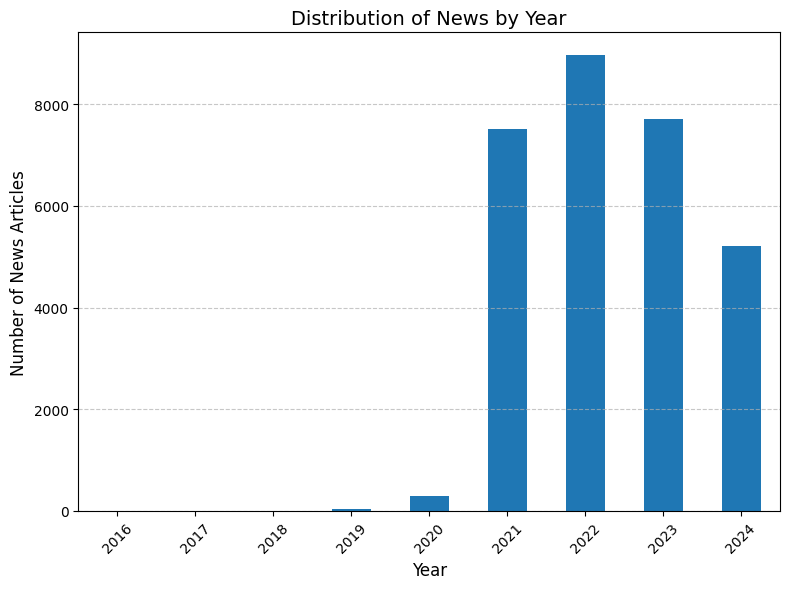

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

filtered_data = data
# 确保 date 列为 datetime 格式
filtered_data['date'] = pd.to_datetime(filtered_data['date'])

# 按年份统计新闻数量
yearly_counts = filtered_data['date'].dt.year.value_counts().sort_index()

# 绘制柱状图
plt.figure(figsize=(8, 6))
yearly_counts.plot(kind='bar')

# 添加图表标题和标签
plt.title("Distribution of News by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of News Articles", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图表
plt.tight_layout()
plt.show()

In [37]:
data = pd.read_csv("/root/repo/Informer2020/sentimental/filtered_data.csv")

In [65]:
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 加载数据
data = pd.read_csv("1/apple_news_data.csv")
data = data.iloc[:5]  # 示例数据
data['date'] = pd.to_datetime(data['date']).dt.strftime('%m-%d-%y')
data['date'] = pd.to_datetime(data['date'], format='%m-%d-%y')

# 筛选日期范围
start_date = "2019-01-01"
end_date = "2024-12-31"
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# 去重：按日期保留第一条记录
filtered_data = filtered_data.drop_duplicates(subset=['date'], keep='first')

# 加载模型和分词器
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model.eval()

# 情感分析函数：返回每个类别的概率
def analyze_sentiment(text):
    if pd.isna(text):
        return [0.0, 1.0, 0.0]  # 默认值：Neutral 的概率为 1
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1).squeeze().tolist()  # 转换为列表
    return probs  # 返回 [Negative, Neutral, Positive] 的概率

# 显式循环处理每一行
predicted_probabilities = []
for _, row in tqdm(filtered_data.iterrows(), total=len(filtered_data), desc="Analyzing sentiments"):
    probabilities = analyze_sentiment(row['content'])
    predicted_probabilities.append(probabilities)

# 将概率拆分为三列并添加到 DataFrame
filtered_data[['pred_negative', 'pred_neutral', 'pred_positive']] = pd.DataFrame(predicted_probabilities, index=filtered_data.index)

# 构建日期 -> 情感分布字典：累积每个类别的概率
sentiment_dict = {}
for date, group in tqdm(filtered_data.groupby('date'), desc="Building sentiment dictionary"):
    total_negative = group['pred_negative'].sum()
    total_neutral = group['pred_neutral'].sum()
    total_positive = group['pred_positive'].sum()
    sentiment_dict[str(date)] = [total_negative, total_neutral, total_positive]

# 打印结果
print(sentiment_dict)

Building sentiment dictionary: 100%|██████████| 2/2 [00:00<00:00, 1053.85it/s]

{'2024-11-26 00:00:00': [7.950251892907545e-05, 0.9998781681060791, 4.2362902604509145e-05], '2024-11-27 00:00:00': [0.9424451589584351, 0.05208266153931618, 0.005472205113619566]}
